In [ ]:
# --- STEP 1: Setup and Mount Google Drive ---
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
import cv2

In [ ]:
# --- STEP 2: Set Paths ---
dataset_dir = '/content/drive/MyDrive/VIIT_Hackathon'
train_dir = dataset_dir
test_dir = dataset_dir


In [ ]:
# --- STEP 3: Filter Only the Desired Classes ---
class_names = ['f', 'n', 'q', 's', 'v']


In [ ]:
# --- STEP 4: Load and Balance the Dataset ---
img_size = 128
max_samples = 2000
f_augment = True

def load_images(folder, label, augment=False):
    paths = glob(os.path.join(folder, '*.png'))
    images = []
    for path in paths:
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (img_size, img_size))
        images.append(img)
        if augment and len(images) < max_samples:
            flipped = cv2.flip(img, 1)
            images.append(flipped)
    images = images[:max_samples]
    labels = [label] * len(images)
    return images, labels

all_images, all_labels = [], []
label_map = {name: i for i, name in enumerate(class_names)}

for name in class_names:
    folder = os.path.join(train_dir, name)
    print(f"Loading {name}...")
    imgs, lbls = load_images(folder, label_map[name], augment=(name == 'f' and f_augment))
    all_images.extend(imgs)
    all_labels.extend(lbls)

X = np.array(all_images).reshape(-1, img_size, img_size, 1) / 255.0
y = to_categorical(all_labels, num_classes=len(class_names))


Loading f...
Loading n...
Loading q...
Loading s...
Loading v...


In [ ]:
print(f"Number of samples: {len(X)}")
print(f"Number of labels: {len(y)}")


Number of samples: 9284
Number of labels: 9284


In [ ]:
# --- STEP 5: Train-Validation Split ---
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=all_labels)

In [ ]:
# --- STEP 6: Define CNN Model ---
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(img_size, img_size, 1)),
    layers.MaxPooling2D(2, 2),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(len(class_names), activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
# --- STEP 7: Compute Class Weights ---
weights = class_weight.compute_class_weight('balanced', classes=np.unique(all_labels), y=all_labels)
class_weights = {i : weights[i] for i in range(len(class_names))}

In [ ]:
# --- STEP 8: Train the Model ---
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=30,
    batch_size=32,
    class_weight=class_weights,
    callbacks=[early_stop]
)

Epoch 1/30
233/233 ━━━━━━━━━━━━━━━━━━━━ 224s 950ms/step - accuracy: 0.5515 - loss: 1.0566 - val_accuracy: 0.9742 - val_loss: 0.0756
Epoch 2/30
233/233 ━━━━━━━━━━━━━━━━━━━━ 292s 1s/step - accuracy: 0.9620 - loss: 0.1069 - val_accuracy: 0.9747 - val_loss: 0.0643
Epoch 3/30
233/233 ━━━━━━━━━━━━━━━━━━━━ 228s 935ms/step - accuracy: 0.9782 - loss: 0.0579 - val_accuracy: 0.9812 - val_loss: 0.0542
Epoch 4/30
233/233 ━━━━━━━━━━━━━━━━━━━━ 266s 954ms/step - accuracy: 0.9854 - loss: 0.0419 - val_accuracy: 0.9833 - val_loss: 0.0429
Epoch 5/30
233/233 ━━━━━━━━━━━━━━━━━━━━ 259s 941ms/step - accuracy: 0.9902 - loss: 0.0263 - val_accuracy: 0.9828 - val_loss: 0.0469
Epoch 6/30
233/233 ━━━━━━━━━━━━━━━━━━━━ 258s 922ms/step - accuracy: 0.9930 - loss: 0.0202 - val_accuracy: 0.9849 - val_loss: 0.0456
Epoch 7/30
233/233 ━━━━━━━━━━━━━━━━━━━━ 257s 900ms/step - accuracy: 0.9882 - loss: 0.0268 - val_accuracy: 0.9736 - val_loss: 0.0836
Epoch 8/30
233/233 ━━━━━━━━━━━━━━━━━━━━ 269s 930ms/step - accuracy: 0.9927 - lo

In [ ]:
# --- STEP 9: Evaluate Model ---
loss, acc = model.evaluate(X_val, y_val)
print(f"Validation Accuracy: {acc*100:.2f}%")

59/59 ━━━━━━━━━━━━━━━━━━━━ 18s 299ms/step - accuracy: 0.9821 - loss: 0.0461
Validation Accuracy: 98.33%


In [ ]:
# --- STEP 10: Save Model ---
model.save('/content/drive/MyDrive/ECG_model_balanced.h5')

In [ ]:
# # --- STEP 11: Predict and Generate Diagnostic Report ---
# def predict_and_report(image_path):
#     img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
#     img_resized = cv2.resize(img, (img_size, img_size)).reshape(1, img_size, img_size, 1) / 255.0
#     prediction = model.predict(img_resized)[0]
#     class_index = np.argmax(prediction)
#     class_confidence = prediction[class_index] * 100
#     class_label = class_names[class_index]

#     diagnosis_map = {
#         'f': 'Fusion of ventricular and normal beat',
#         'n': 'Normal beat',
#         'q': 'Unclassifiable beat',
#         's': 'Supraventricular premature beat',
#         'v': 'Premature ventricular contraction'
#     }
#     condition = 'Normal' if class_label == 'n' else 'Abnormal'
#     recommendation = 'No action needed.' if condition == 'Normal' else 'Consult a cardiologist.'

#     print("\n🩺 ECG Diagnostic Report")
#     print("--------------------------")
#     print(f"Prediction: {diagnosis_map[class_label]} ({class_label.upper()})")
#     print(f"Condition: {condition}")
#     print(f"Confidence: {class_confidence:.2f}%")
#     print(f"Advice: {recommendation}")

#     # Annotated Image
#     annotated = cv2.putText(cv2.cvtColor(img, cv2.COLOR_GRAY2BGR), f"{diagnosis_map[class_label]}",
#                             (10, 25), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0,0,255), 2)
#     plt.imshow(annotated)
#     plt.title("Annotated ECG Image")
#     plt.axis('off')
#     plt.show()

# # Example Usage:
# predict_and_report('/content/drive/MyDrive/Test Images/f/F0.png')

import datetime

def predict_and_report(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    img_resized = cv2.resize(img, (img_size, img_size)).reshape(1, img_size, img_size, 1) / 255.0
    prediction = model.predict(img_resized)[0]
    class_index = np.argmax(prediction)
    class_confidence = prediction[class_index] * 100
    class_label = class_names[class_index]

    # Medical explanation and lifestyle advice
    diagnosis_map = {
        'f': {
            'name': 'Fusion of ventricular and normal beat',
            'explanation': 'A fusion beat happens when two heart signals collide, indicating electrical instability.',
            'diet': 'Avoid caffeine, reduce stress, eat potassium-rich foods like bananas.',
            'exercise': 'Gentle cardio like walking or swimming.',
        },
        'n': {
            'name': 'Normal beat',
            'explanation': 'Your heartbeat looks perfectly normal.',
            'diet': 'Continue with a balanced diet.',
            'exercise': 'Maintain regular physical activity.',
        },
        'q': {
            'name': 'Unclassifiable beat',
            'explanation': 'The beat pattern is unclear and doesn’t match known types. May need further analysis.',
            'diet': 'Avoid stimulants, eat heart-healthy foods.',
            'exercise': 'Mild physical activity; monitor symptoms.',
        },
        's': {
            'name': 'Supraventricular premature beat',
            'explanation': 'Early heartbeat from the upper heart chamber. Often stress or caffeine induced.',
            'diet': 'Reduce caffeine, alcohol, and processed sugar.',
            'exercise': 'Yoga, light stretching, or walking.',
        },
        'v': {
            'name': 'Premature ventricular contraction',
            'explanation': 'Extra beats from the lower chamber. Might feel like a skipped beat.',
            'diet': 'High magnesium and potassium intake; avoid stimulants.',
            'exercise': 'Avoid overexertion; light cardio recommended.',
        }
    }

    diag = diagnosis_map[class_label]
    condition = 'Normal' if class_label == 'n' else 'Abnormal'
    recommendation = 'No action needed.' if condition == 'Normal' else 'Consult a cardiologist soon.'

    print("\n🩺 ECG Diagnostic Report")
    print("--------------------------")
    print(f"🕐 Time: {datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
    print(f"Prediction: {diag['name']} ({class_label.upper()})")
    print(f"Confidence: {class_confidence:.2f}%")
    print(f"Condition: {condition}")
    print(f"Explanation: {diag['explanation']}")
    print(f"Diet Tip: {diag['diet']}")
    print(f"Exercise Tip: {diag['exercise']}")
    print(f"Advice: {recommendation}")

    # Annotate image
    annotated = cv2.putText(cv2.cvtColor(img, cv2.COLOR_GRAY2BGR), f"{diag['name']}",
                            (10, 25), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 255), 2)
    plt.imshow(annotated)
    plt.title("Annotated ECG Image")
    plt.axis('off')
    plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step

🩺 ECG Diagnostic Report
--------------------------
🕐 Time: 2025-04-23 18:44:34
Prediction: Fusion of ventricular and normal beat (F)
Confidence: 100.00%
Condition: Abnormal
Explanation: A fusion beat happens when two heart signals collide, indicating electrical instability.
Diet Tip: Avoid caffeine, reduce stress, eat potassium-rich foods like bananas.
Exercise Tip: Gentle cardio like walking or swimming.
Advice: Consult a cardiologist soon.


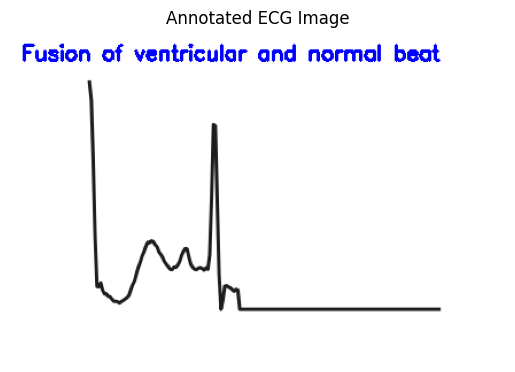

In [ ]:
predict_and_report('/content/drive/MyDrive/Test Images/f/F118.png')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step

🩺 ECG Diagnostic Report
--------------------------
🕐 Time: 2025-04-23 18:43:59
Prediction: Fusion of ventricular and normal beat (F)
Confidence: 100.00%
Condition: Abnormal
Explanation: A fusion beat happens when two heart signals collide, indicating electrical instability.
Diet Tip: Avoid caffeine, reduce stress, eat potassium-rich foods like bananas.
Exercise Tip: Gentle cardio like walking or swimming.
Advice: Consult a cardiologist soon.


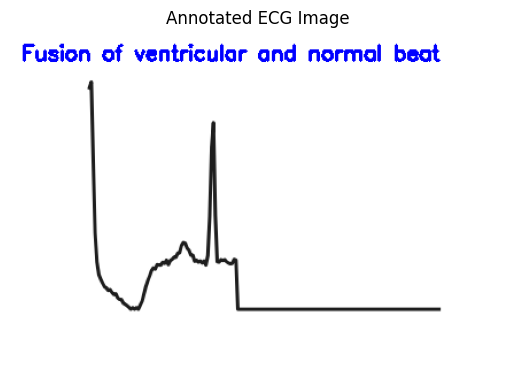

In [ ]:
predict_and_report('/content/drive/MyDrive/Test Images/f/F19.png')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step

🩺 ECG Diagnostic Report
--------------------------
Prediction: Fusion of ventricular and normal beat (F)
Condition: Abnormal
Confidence: 100.00%
Advice: Consult a cardiologist.


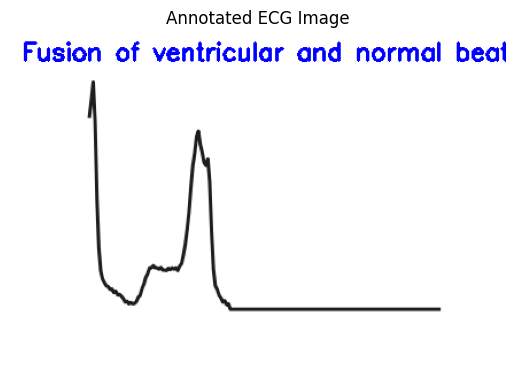

In [ ]:
predict_and_report('/content/drive/MyDrive/Test Images/f/F211.png')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step

🩺 ECG Diagnostic Report
--------------------------
Prediction: Normal beat (N)
Condition: Normal
Confidence: 99.92%
Advice: No action needed.


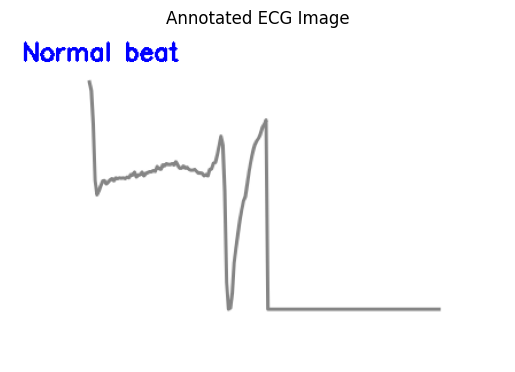

In [ ]:
predict_and_report('/content/drive/MyDrive/Test Images/n/N37.png')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step

🩺 ECG Diagnostic Report
--------------------------
Prediction: Premature ventricular contraction (V)
Condition: Abnormal
Confidence: 99.83%
Advice: Consult a cardiologist.


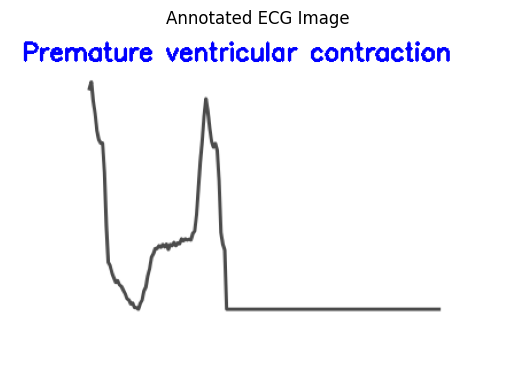

In [ ]:
predict_and_report('/content/drive/MyDrive/Test Images/v/V21.png')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step

🩺 ECG Diagnostic Report
--------------------------
Prediction: Unclassifiable beat (Q)
Condition: Abnormal
Confidence: 99.87%
Advice: Consult a cardiologist.


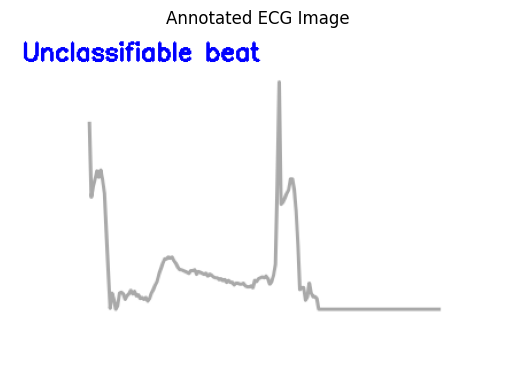

In [ ]:
predict_and_report('/content/drive/MyDrive/Test Images/q/Q22.png')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step

🩺 ECG Diagnostic Report
--------------------------
Prediction: Supraventricular premature beat (S)
Condition: Abnormal
Confidence: 99.71%
Advice: Consult a cardiologist.


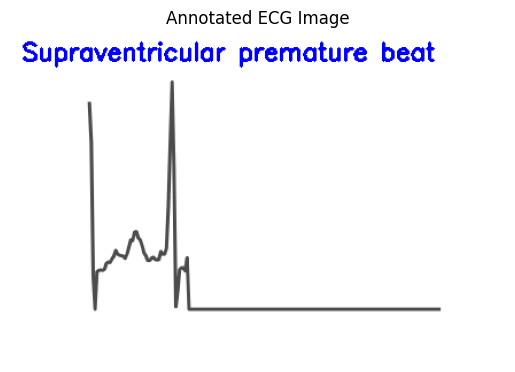

In [ ]:
predict_and_report('/content/drive/MyDrive/Test Images/s/S36.png')

In [ ]:
!pip install fpdf

  Preparing metadata (setup.py) ... done
  Created wheel for fpdf: filename=fpdf-1.7.2-py2.py3-none-any.whl size=40704 sha256=f76871e92a4f92095d14f8a9f236b337bbbfad1d52c313a34e39656941510e1c
  Stored in directory: /root/.cache/pip/wheels/65/4f/66/bbda9866da446a72e206d6484cd97381cbc7859a7068541c36
Successfully built fpdf


In [ ]:
from fpdf import FPDF
import datetime

def export_pdf(image_path, diagnosis, confidence, advice):
    pdf = FPDF()
    pdf.add_page()
    pdf.set_font("Arial", size=12)
    pdf.cell(200, 10, txt="ECG Diagnostic Report", ln=True, align='C')
    pdf.cell(200, 10, txt=f"Date: {datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')}", ln=True)
    pdf.cell(200, 10, txt=f"Diagnosis: {diagnosis}", ln=True)
    pdf.cell(200, 10, txt=f"Confidence: {confidence:.2f}%", ln=True)
    pdf.multi_cell(200, 10, txt=f"Advice: {advice}")
    pdf.image(image_path, x=10, y=None, w=100)
    pdf.output("ecg_report.pdf")
